In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Path to the dataset
PATH = '/kaggle/input/utkface-new/UTKFace'

In [3]:
# Step 1: Load images and labels
image_paths = []
age_labels = []

for filename in os.listdir(PATH):
    image_path = os.path.join(PATH, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

In [4]:
# Convert to numpy arrays
image_paths = np.array(image_paths)
age_labels = np.array(age_labels)

In [5]:
# Prepare low-res and high-res image pairs
low_res_images = []
high_res_images = []

for image_path in image_paths:
    img = load_img(image_path, target_size=(128, 128))  # High resolution
    img_array_high = img_to_array(img)

    img_low_res = load_img(image_path, target_size=(32, 32))  # Low resolution
    img_array_low = img_to_array(img_low_res)

    high_res_images.append(img_array_high)  # Ground truth for SRCNN
    low_res_images.append(img_array_low)  # Input for SRCNN

In [6]:
# Normalize image data
low_res_images = np.array(low_res_images) / 255.0
high_res_images = np.array(high_res_images) / 255.0

In [7]:
# Split into training and validation sets
X_train_lr, X_testval_lr, y_train_hr, y_testval_hr, age_labels_train, age_labels_testval = train_test_split(low_res_images, high_res_images, age_labels, test_size=0.2, random_state=42)
X_val_lr, X_test_lr, y_val_hr, y_test_hr, age_labels_val, age_labels_test = train_test_split(X_testval_lr, y_testval_hr, age_labels_testval, test_size=0.5, random_state=42)

In [8]:
# Step 2: Define the SRCNN model
def create_srcnn(input_shape):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        Conv2D(64, kernel_size=(9, 9), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same'),
        UpSampling2D(size=(4, 4)),  # Upscale to 128x128
        Conv2D(3, kernel_size=(5, 5), activation='linear', padding='same')  # 3 channels for RGB
    ])
    return model

srcnn = create_srcnn((32, 32, 3))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [9]:
# Define SSIM loss
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [10]:
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [11]:
# Compile SRCNN
srcnn.compile(optimizer=Adam(learning_rate=1e-4), loss=ssim_loss, metrics=['mse', ssim_metric])

In [12]:
# Train SRCNN
history_srcnn = srcnn.fit(
    X_train_lr, y_train_hr,  # Input is low-res, ground truth is high-res
    validation_data=(X_val_lr, y_val_hr),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - loss: 0.3120 - mse: 0.0275 - ssim_metric: 0.6880 - val_loss: 0.1279 - val_mse: 0.0029 - val_ssim_metric: 0.8723
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.1246 - mse: 0.0028 - ssim_metric: 0.8754 - val_loss: 0.1212 - val_mse: 0.0024 - val_ssim_metric: 0.8790
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.1182 - mse: 0.0023 - ssim_metric: 0.8818 - val_loss: 0.1177 - val_mse: 0.0021 - val_ssim_metric: 0.8825
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.1161 - mse: 0.0021 - ssim_metric: 0.8839 - val_loss: 0.1158 - val_mse: 0.0020 - val_ssim_metric: 0.8844
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.1147 - mse: 0.0020 - ssim_metric: 0.8853 - val_loss: 0.1144 - val_mse: 0.0020 - val_ssim_metric: 0.8857
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.1142 - mse: 0.0020 - ssim_metric: 0.8858 - val_loss: 0.1138 - val_mse: 0.0019 - val_ssim_metric:

In [13]:
test_metrics = srcnn.evaluate(X_test_lr, y_test_hr, batch_size=32, verbose=1)
print(f"Test Loss (SSIM Loss): {test_metrics[0]}")
print(f"Test MSE: {test_metrics[1]}")
print(f"Test SSIM: {test_metrics[2]}")  # Assuming SSIM is the third metric

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1031 - mse: 0.0017 - ssim_metric: 0.8969
Test Loss (SSIM Loss): 0.1024831011891365
Test MSE: 0.001678207772783935
Test SSIM: 0.8974521160125732


In [14]:
# Upscale images using the trained SRCNN
def upscale_images(srcnn_model, images):
    return srcnn_model.predict(images)

In [15]:
X_train_upscaled = upscale_images(srcnn, X_train_lr)
X_val_upscaled = upscale_images(srcnn, X_val_lr)
X_test_upscaled = upscale_images(srcnn, X_test_lr)

593/593 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


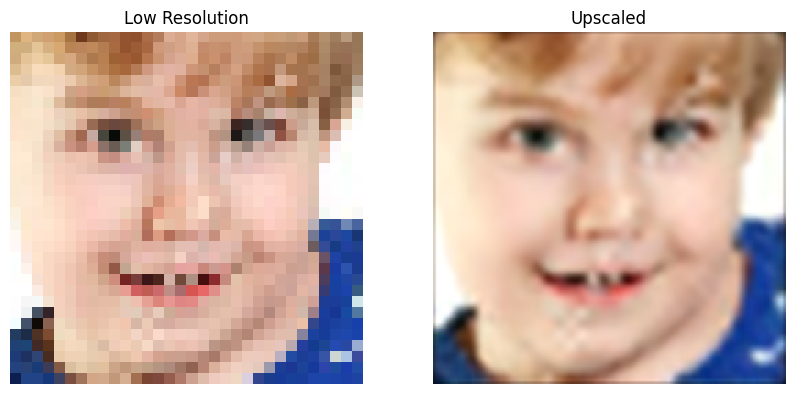

In [16]:
# Visualize one image before and after upscaling
index = 0  # Index of the image to visualize

plt.figure(figsize=(10, 5))

# Low-resolution image
plt.subplot(1, 2, 1)
plt.title("Low Resolution")
plt.imshow(X_test_lr[index])
plt.axis('off')

# Upscaled image
plt.subplot(1, 2, 2)
plt.title("Upscaled")
plt.imshow(X_test_upscaled[index])
plt.axis('off')

plt.show()

In [17]:
# Data augmentation for the regression model
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train_upscaled)

In [18]:
# Step 4: Define the regression model
def create_regression_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN feature extractor
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)

    # Regression output
    predicted_age = Dense(1, activation='linear', name='age_out')(x)

    model = Model(inputs=inputs, outputs=predicted_age)
    return model

regression_model = create_regression_model((128, 128, 3))

In [19]:
# Compile the regression model
regression_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='mse', 
    metrics=['mae']
)

In [22]:
# Callbacks
model_save_path = '/kaggle/working/srcnn_coral_model.keras'
regression_model.save(model_save_path)

checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [23]:
# Train the regression model
history_regression = regression_model.fit(
    datagen.flow(X_train_upscaled, age_labels_train, batch_size=32),
    validation_data=(X_val_upscaled, age_labels_val),
    epochs=100,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


593/593 ━━━━━━━━━━━━━━━━━━━━ 77s 119ms/step - loss: 459.9970 - mae: 16.4235 - val_loss: 281.4294 - val_mae: 12.4721 - learning_rate: 0.0010
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 65s 109ms/step - loss: 289.6749 - mae: 13.0308 - val_loss: 258.8547 - val_mae: 11.5049 - learning_rate: 0.0010
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - loss: 250.2422 - mae: 12.0111 - val_loss: 261.7092 - val_mae: 11.5173 - learning_rate: 0.0010
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - loss: 225.7726 - mae: 11.2556 - val_loss: 168.1481 - val_mae: 9.4081 - learning_rate: 0.0010
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - loss: 187.7224 - mae: 10.3197 - val_loss: 160.0509 - val_mae: 9.3988 - learning_rate: 0.0010
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - loss: 178.9760 - mae: 10.0682 - val_loss: 157.8861 - val_mae: 8.9995 - learning_rate: 0.0010
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - loss: 166.0533 - mae: 9.6747 - val_loss: 139.

In [24]:
# Load the best model
model = tf.keras.models.load_model('/kaggle/working/srcnn_coral_model.keras')

In [25]:
# Step 5: Evaluate the regression model
loss, mae = model.evaluate(X_test_upscaled, age_labels_test, verbose=1)

print(f"Regression Mean Squared Error (MSE): {loss:.4f}")
print(f"Regression Mean Absolute Error (MAE): {mae:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 78.3819 - mae: 6.4426
Regression Mean Squared Error (MSE): 76.6014
Regression Mean Absolute Error (MAE): 6.3550


In [28]:
# Predictions
y_pred = model.predict(X_test_upscaled, verbose=1)

# Metrics Calculation
mse = mean_squared_error(age_labels_test, y_pred)
mae = mean_absolute_error(age_labels_test, y_pred)
r2 = r2_score(age_labels_test, y_pred)

print(f"Regression Mean Squared Error (MSE): {mse:.4f}")
print(f"Regression Mean Absolute Error (MAE): {mae:.4f}")
print(f"Regression R² Score: {r2:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Regression Mean Squared Error (MSE): 76.6014
Regression Mean Absolute Error (MAE): 6.3550
Regression R² Score: 0.8032


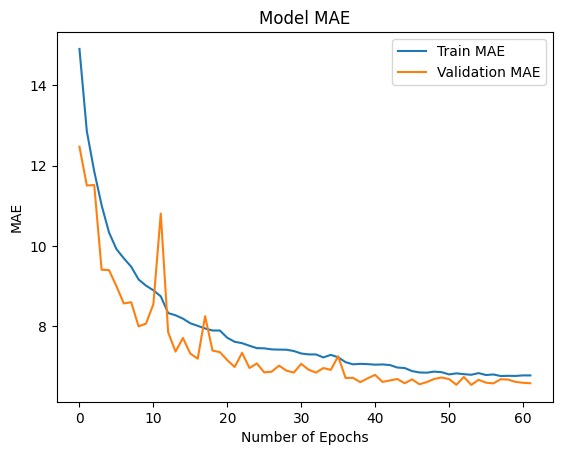

In [29]:
# Plot MAE
plt.plot(history_regression.history['mae'], label='Train MAE')
plt.plot(history_regression.history['val_mae'], label='Validation MAE')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('MAE')
plt.title('Model MAE')
plt.show()

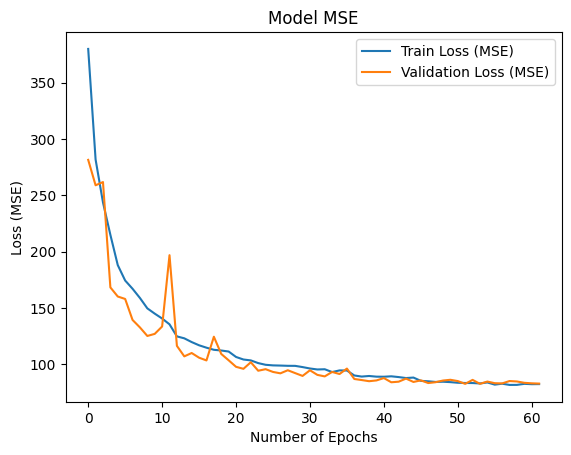

In [30]:
# Plot Loss (MSE)
plt.plot(history_regression.history['loss'], label='Train Loss (MSE)')
plt.plot(history_regression.history['val_loss'], label='Validation Loss (MSE)')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model MSE')
plt.show()